In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Mounted at /content/mydrive


In [ ]:
 ! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 122 (delta 15), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (122/122), 1.27 MiB | 9.58 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [ ]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
 !bash install_mecab-ko_on_colab_light_220429.sh

In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()
text = u"""이제 구글 코랩에서 Mecab-ko라이브러리 사용이 가능합니다. 읽어주셔서 감사합니다."""
nouns = mecab.nouns(text)
print(nouns)

['구글', '랩', '라이브러리', '사용', '가능', '감사']


- 실제로 메캅 사용한 토큰을 사용하긴 했는데, ppt에는 kkma로 토크나이징한 words 썼다고 할 예정...
---

In [ ]:
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install --upgrade sentencepiece
!pip install transformers
!pip install torch

In [ ]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

### 패키지 임포트 & 파일 읽기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tqdm import tqdm, tqdm_notebook

import gluonnlp as nlp # 얘 import안되면 컴퓨터 재부팅
import sentencepiece
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

# Device 설정(GPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
df = pd.read_csv('/content/mydrive/MyDrive/pos_dataframe.csv')
df.head()

In [ ]:
df.dropna(subset=['words'], axis=0,inplace=True)

In [ ]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
import pickle
import csv
import pandas as pd
from pandas import DataFrame
import numpy as np

In [ ]:
from konlpy.tag import Okt, Kkma

In [ ]:
df.dropna(subset=['words'], axis=0, inplace=True)

In [ ]:
to_str = []
for i in range(0, len(df)):
  to_str.append(''.join(df['real_review'][i]))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
txt = df['review_txt'].unique().tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 데이터 전처리
- mecab tokenizing

In [ ]:
### data preprocessing
def clean_text(text):
    text = text.replace(".", "").strip()
    text = text.replace("·", " ").strip()
    pattern = '[^ ㄱ-ㅣ가-힣|0-9]+'
    text = re.sub(pattern=pattern, repl='', string=text)
    return text


def get_nouns(tokenizer, sentence):
    tagged = tokenizer.pos(sentence)
    nouns = [s for s, t in tagged if t in ['NNG', 'NNP', 'VA', 'XR'] and len(s) >1]
    return nouns

def tokenize(df):
    tokenizer = Mecab(dicpath='/usr/local/lib/mecab/dic/mecab-ko-dic')
    processed_data = []
    for sent in tqdm(df['review_txt']):
        sentence = clean_text(str(sent).replace("\n", "").strip())
        processed_data.append(get_nouns(tokenizer, sentence))
    return processed_data
    # tokenizer = Okt()
    # processed_data = []
    # for sent in tqdm(df['sentence']):
    #   sentence = clean_text(str(sent))
    #   processed_data.append(get_nouns(tokenizer, sent))

def save_processed_data(processed_data):
    with open("tokenized_data_43.csv", 'w', newline="", encoding='utf-8') as f:
        writer = csv.writer(f)
        for data in processed_data:
            writer.writerow(data)

# if __name__ == '__main__':
#     df = pd.read_csv("/content/mydrive/MyDrive/pos_dataframe.csv")
#     #df.columns=['user', 'date', 'time', 'text', 'comment', 'like', 'share']
#     #df.dropna(how='any')
#     processed_data = tokenize(df['sentence'])
#     save_processed_data(processed_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
processed_data = tokenize(df) # 교정 완료한 리뷰 다시 하나로 합쳐서 mecab tokenizing

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 305313/305313 [01:08<00:00, 4436.97it/s]


In [ ]:
save_processed_data(processed_data)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head() # 토큰을 전처리 해서 컬럼으로 추가함

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Unnamed: 0,id,rank,company,name1,name2,category,volume,alc,type,...,score,real_date,buy,real_review,split_sentences,sentence,normalized,words,review_txt,processed_data
0,0,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",상한 겁니까,상한 겁니까,상한 걸,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"[그래프, 신맛, 상태, 처음, 도착, 택배, 상태, 경악, 아파트, 분리수거, 농..."
1,1,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",구매확정합니다,구매확정합니다,구매 확정,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"[그래프, 신맛, 상태, 처음, 도착, 택배, 상태, 경악, 아파트, 분리수거, 농..."
2,2,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",올바른 상품이 왔더니 이건 도대체 다시는 여기 거 안 먹습니다,올바른 상품이 왔더니 이건 도대체 다시는 여기 거 안 먹습니다,올바르 상품 오 그 먹,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"[그래프, 신맛, 상태, 처음, 도착, 택배, 상태, 경악, 아파트, 분리수거, 농..."
3,3,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",올바른 상태,올바른 상태,올바르 상태,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"[그래프, 신맛, 상태, 처음, 도착, 택배, 상태, 경악, 아파트, 분리수거, 농..."
4,4,1,1,배상면주가,느린마을 막걸리,느린마을 막걸리 6도,막걸리/탁주,750,6.0,페트병,...,1,21.02.21.,인터파크쇼핑,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"['상한겁니까?', '아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까?', '처음...",저번에 시킨 박스는 제품 상하 뒤집지 말아달란 스티커와 올바른 박스,저번에 시킨 박스는 제품 상하 뒤집지 말아달란 스티커와 올바른 박스,저번 시키 박스 제품 상하 뒤집 말 스티커 올바르 박스,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,"[그래프, 신맛, 상태, 처음, 도착, 택배, 상태, 경악, 아파트, 분리수거, 농..."


In [ ]:
df['processed_data'] = processed_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.to_csv('processed_data_df43.csv', encoding='utf-8')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.dropna(subset=['words'], axis=0, inplace=True) # 빈 토큰 드롭

In [ ]:
processed_data = [sent.strip().split(",") for sent in tqdm(open("tokenized_data_.csv",'r',encoding='utf-8').readlines())] # ,로 쪼갬
processed_data = DataFrame(processed_data)
processed_data[0] = processed_data[0].replace("", np.nan) # 비었으면 nan으로 처리
processed_data = processed_data[processed_data[0].notnull()] # nan 아닌 것만 가져오기
processed_data = processed_data.values.tolist() # 토큰들 리스트로 변환

processed_data2=[]
for i in processed_data:
  i = list(filter(None, i))
  processed_data2.append(i)

processed_data = processed_data2
processed_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 305313/305313 [00:02<00:00, 129936.55it/s]


[['구매', '확정'],
 ['상품'],
 ['상태'],
 ['저번', '박스', '제품', '상하', '스티커', '박스'],
 ['아버지', '죄송'],
 ['신맛', '쓴맛', '생각'],
 ['만족'],
 ['저번', '주문'],
 ['생각'],
 ['전통주', '얼굴', '똥칠'],
 ['장난'],
 ['중요', '음료', '상태'],
 ['부오'],
 ['농가', '반년'],
 ['아파트', '분리수거'],
 ['처음', '도착', '택배', '상태', '경악'],
 ['그래프', '신맛', '상태'],
 ['쓴맛'],
 ['구매', '의사'],
 ['처음', '주문', '부드럽', '맛있'],
 ['박스', '손상', '배송'],
 ['감사'],
 ['변비', '설사'],
 ['동생', '소화', '변비', '효과'],
 ['맛있'],
 ['감탄', '뿌듯'],
 ['맛있', '마을', '이번', '집들이', '준비', '맛있'],
 ['손님'],
 ['저렴'],
 ['감사'],
 ['맛있'],
 ['맛있'],
 ['구매'],
 ['숙성'],
 ['맛있'],
 ['처음', '맛있'],
 ['부모', '옛날'],
 ['맛있'],
 ['인위', '단맛'],
 ['머리'],
 ['강추'],
 ['맛있'],
 ['구매', '의사'],
 ['맛있'],
 ['김치냉장고', '숙성'],
 ['주일', '개인'],
 ['포장', '깔끔', '만족'],
 ['만족'],
 ['편의점', '결국', '주문'],
 ['포장', '꼼꼼', '배송'],
 ['마트', '재고', '막걸리', '제조', '주문', '당일', '제조'],
 ['다음', '택배', '도착'],
 ['맛있', '배송', '완벽'],
 ['맛있', '인생', '막걸리'],
 ['선물', '주문'],
 ['나라', '전통', '곡주', '막걸리', '맛있'],
 ['맛있'],
 ['배송', '빠르'],
 ['막걸리', '최고', '맛나'],
 ['가격', '대비', '괜찮'],
 ['단맛'],
 [

In [ ]:
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## 입력 데이터 형태 변환

In [ ]:
dictionary = corpora.Dictionary(processed_data) # 딕셔너리 형태로 변환
dictionary.filter_extremes(no_below=2, no_above=0.5) # 2글자 이하 제거
corpus = [dictionary.doc2bow(text) for text in processed_data] # bag-of-words 형식으로 맞춰야 LDA 입력 가능

## Modeling

In [ ]:
num_topics = 4
chunksize = 2000
passes = 20
iterations = 400
eval_every = None

temp = dictionary[0]
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

In [ ]:
# tokenized_data = []
# for i in range(len(df)):
#   tokenized_data.append(eval(df['processed_data'].iloc[i]))

# 위에서 전처리, 형태 변환 마친 데이터 tokenized_data에 넣기
tokenized_data = processed_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd
import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents
#dictionary = Dictionary(tokenized_data)

# Create a bag-of-words representation of the documents
#corpus = [dictionary.doc2bow(sentence) for sentence in tokenized_data]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 문서에 토픽 할당

In [ ]:
# Assign topics to the documents in the DataFrame
topic_assignments = []
for sentence in tokenized_data:
    bow_vector = dictionary.doc2bow(sentence)
    topic_distribution = model.get_document_topics(bow_vector)
    topic_assignment = max(topic_distribution, key=lambda x: x[1])[0]
    topic_assignments.append(topic_assignment)

# Add the topic assignments to the DataFrame
df['topic'] = topic_assignments

In [ ]:
file_name = './top_topics.txt'

with open(file_name, 'w+') as file:
    for num, i in enumerate(str(top_topics)):
        if num+1 < len(top_topics):
            file.write(', '.join(i) + "\n")
        else:
            file.write(', '.join(i))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 시각화

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 103.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 39.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.12.0 

In [ ]:
import pickle
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [ ]:
import gensim

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!pip install pandas==1.5.3 # 버전 1.5.3으로 맞춰야 시각화 가능

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    Uninstalling pandas-2.0.3:
      Successfully uninstalled pandas-2.0.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
import pandas as pd

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_visualization = gensimvis.prepare(model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_visualization, '/content/mydrive/MyDrive/lda_vis22.html')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model.get_topics()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[1.3755972e-06, 1.4322568e-06, 1.3845400e-06, ..., 1.2059771e-05,
        2.5187281e-05, 2.3907003e-05],
       [3.4437257e-06, 3.6138028e-06, 3.4495056e-06, ..., 4.4565284e-05,
        1.4998649e-05, 3.1555373e-05],
       [3.0387378e-06, 3.1065861e-06, 3.0126673e-06, ..., 2.4295628e-05,
        1.5359952e-05, 1.7672965e-05],
       [1.6911583e-06, 1.0503360e-01, 1.6367549e-06, ..., 1.2536892e-05,
        3.7517297e-05, 3.1887394e-05]], dtype=float32)

## 최종 사용하진 않았지만 Clustering

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import numpy as np

# KoBERT 모델 로드
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = BertModel.from_pretrained('monologg/kobert')

# 리뷰 데이터
#reviews = [
#    "전통주 맛이 좋아요.",
#    "리뷰 쓰기가 귀찮아요.",
#    "이 전통주는 가격이 비싸요.",
#    "냄새가 좋지 않아요.",
#    "전통주를 추천합니다."
#]

reviews = df['words'][:1000].tolist()

# 리뷰 데이터 전처리 및 임베딩
embeddings = []
for review in reviews:
    input_ids = torch.tensor([tokenizer.encode(review, add_special_tokens=True)])
    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_states = outputs.last_hidden_state
        embedding = torch.mean(last_hidden_states, dim=1).squeeze().numpy()
        embeddings.append(embedding)

# K-means 클러스터링
num_clusters = 4  # 클러스터의 개수
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(embeddings)
cluster_labels = kmeans.labels_


# 클러스터링 결과 출력
for i, review in enumerate(reviews):
    cluster_label = cluster_labels[i]
    print(f"리뷰: {review} / 클러스터: {cluster_label}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


리뷰: 상한 걸 / 클러스터: 2
리뷰: 구매 확정 / 클러스터: 1
리뷰: 올바르 상품 오 그 먹 / 클러스터: 2
리뷰: 올바르 상태 / 클러스터: 2
리뷰: 저번 시키 박스 제품 상하 뒤집 말 스티커 올바르 박스 / 클러스터: 0
리뷰: 더불 병 아버지 드시 / 클러스터: 2
리뷰: 맛 신 맛 쓴맛 나 상하 같 생각 화 치밀 / 클러스터: 0
리뷰: 만족 / 클러스터: 1
리뷰: 저번 병 주문 먹 / 클러스터: 2
리뷰: 상하 / 클러스터: 1
리뷰: 먹 생각 / 클러스터: 2
리뷰: 좋 술 전통주 자시 하 얼굴 똥칠 하 / 클러스터: 0
리뷰: 장난 / 클러스터: 1
리뷰: 중요 건 음료 상 태 / 클러스터: 0
리뷰: 부 오 넘어가 하 / 클러스터: 2
리뷰: 그러 하 / 클러스터: 2
리뷰: 농가 반년 흙 밭 쓰 구르 골르 / 클러스터: 0
리뷰: 아파트 단지 분리수거함 보 배 낫 / 클러스터: 2
리뷰: 죠 / 클러스터: 2
리뷰: 처음 도착 때 택배 상태 보 경악 / 클러스터: 0
리뷰: 아니 그래프 보 신맛 끝 간 상태 / 클러스터: 0
리뷰: 먹 풍기 쓴맛 / 클러스터: 2
리뷰: 구매 의사 / 클러스터: 1
리뷰: 처음 주문 부드럽 맛있 / 클러스터: 0
리뷰: 박스 손상 배송 / 클러스터: 0
리뷰: 먹 있 / 클러스터: 3
리뷰: 감사 / 클러스터: 3
리뷰: 변비 신 불 드 / 클러스터: 2
리뷰: 요 / 클러스터: 3
리뷰: 동생 저 소화 변비 효과 보고 있 / 클러스터: 0
리뷰: 먹 있 / 클러스터: 3
리뷰: 맛있 좋 / 클러스터: 0
리뷰: 좋 감탄 / 클러스터: 3
리뷰: 맛있 먹 느리 마을 이번 집들이 준비 맛있 먹 / 클러스터: 0
리뷰: 손님 모두 목 넘기 / 클러스터: 0
리뷰: 맛 좋 / 클러스터: 2
리뷰: 감사 / 클러스터: 3
리뷰: 맛있 / 클러스터: 1
리뷰: 처음 먹 맛있 / 클러스터: 2
리뷰: 구매 / 클러스터: 1
리뷰: 숙성 전 먹 / 클러스터: 2
리뷰: 맛있 / 클러스터: 1
리뷰: 처음 시키 

In [ ]:
df2 = pd.DataFrame(reviews)

In [ ]:
df2['cluster']=kmeans.labels_

In [ ]:
df2

,0,cluster
0,상한 걸,1
1,구매 확정,2
2,올바르 상품 오 그 먹,1
3,올바르 상태,1
4,저번 시키 박스 제품 상하 뒤집 말 스티커 올바르 박스,3
...,...,...
995,냉장고 쟁이 맘,3
996,술 향기 좋,3
997,야무지,2
998,느리 막걸리 빠지,3


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

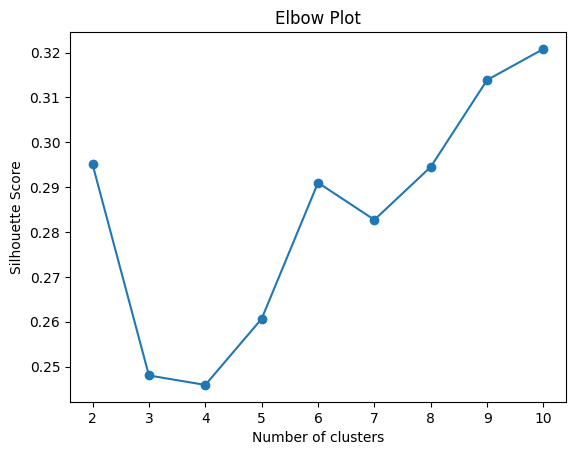

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# 클러스터 개수 범위
min_clusters = 2
max_clusters = 10

# K-means 클러스터링과 Elbow plot 그리기
cluster_scores = []
for num_clusters in range(min_clusters, max_clusters+1):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(embeddings)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(embeddings, cluster_labels)
    cluster_scores.append(silhouette_avg)

# Elbow plot 그리기
plt.plot(range(min_clusters, max_clusters+1), cluster_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Elbow Plot')
plt.show()


In [ ]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 31.8 MB/s eta 0:00:00


In [ ]:
df2.columns = ['real_review', 'cluster']

In [ ]:
## tokenizing
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer

# Okt 객체 생성
okt = Okt()

# 텍스트 토큰화 함수
def preprocess(text):
    tokens = okt.pos(text, norm=True, stem=True)
    tokens = [word for word, pos in tokens if pos in ['Noun', 'Verb', 'Adjective']]  # 명사, 동사, 형용사만 추출

    stopwords = ['전통주', '술', '이', '구매', '보다', '도착']  # 사용자 정의 불용어 추가
    filtered_tokens = [token for token in tokens if token not in stopwords]
    filtered_tokens = ' '.join(filtered_tokens)
    #filtered_tokens = [filtered_tokens]
    return filtered_tokens


# 텍스트 토큰화 수행 예시
#text = "전통주의 맛과 향은 최고입니다."
result = preprocess(df2['real_review'][0])
print(result)


상한 겁 아니다 그래프 신맛 끝 간 상태 입 처음 하다 때 택배 상태 보고 경악 하다 뭐 아파트 단지 분리수거 함 거 배다 낫다 농가 반년 흙밭 구르다 걸 고르다 그렇다 하다 부오 그냥 넘어가다 하다 중요하다 음료 상태 요 장난 합 먹다 확 풍기다 쓴맛 먹다 생각 하다 거 상한 거 아니다 저번 병 주문 하다 먹다 만족하다 완전 맛 신맛 쓴맛 나다 거 상한 거 같다 생각 화가 치 미네 더불다 병 아버지 들다 죄송하다 거 좋다 자시 하다 제 얼굴 똥칠 하다 저번 시키다 박스 제품 상하 뒤지다 말 달다 스티커 박스 올바르다 상태 올바르다 상품 오다 것 도대체 다시다 여기다 먹다 확정 하다


In [ ]:
### sample code - cluster

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 텍스트 데이터
# reviews = [
#     "전통주 맛이 좋아요.",
#     "리뷰 쓰기가 귀찮아요.",
#     "이 전통주는 가격이 비싸요.",
#     "냄새가 좋지 않아요.",
#     "전통주를 추천합니다."
# ]

#reviews = df2[df2['cluster']==0]['real_review']
reviews = df2['real_review']

# 클러스터 번호
cluster_idx = 0

# 클러스터 내 리뷰 수집
cluster_reviews = [review for i, review in enumerate(reviews) if cluster_labels[i] == cluster_idx]

# 토픽 추출 함수
def extract_topics(cluster_reviews):
    # 텍스트 전처리
    processed_reviews = cluster_reviews  # 필요한 전처리 과정을 수행하십시오.

    # 토픽 추출 모델 생성
    vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english')
    X = vectorizer.fit_transform(processed_reviews)
    feature_names = vectorizer.get_feature_names_out()
    lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
    lda_model.fit(X)

    # 각 토픽별로 키워드 출력
    for topic_idx, topic in enumerate(lda_model.components_):
        print("토픽 %d:" % (topic_idx+1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
        print()

# 클러스터 내 리뷰로 토픽 추출
for k in range(4):
  print(k)
  cluter_idx = k
  cluster_reviews = [review for i, review in enumerate(reviews) if cluster_labels[i] == cluster_idx]
  print("클러스터 %d" % cluster_idx)
  extract_topics(cluster_reviews)


0
클러스터 0
토픽 1:
부드럽고, 너무, 맛있어요, 막걸리, 좋아요, ㅎㅎ, 정말, 진짜, 맛이, 느린마을

토픽 2:
막걸리, 좋아요, 맛이, 막걸리는, 맛있어요, 부드럽고, 목넘김이, 느린마을, 맛있게, 계속

토픽 3:
너무, 맛있어요, 배송, 진짜, 제가, 막걸리, 감사합니다, 막걸리를, 맛도, 조금

토픽 4:
너무, 배송도, 좋아요, 포장도, 빠르고, 맛있어요, 맛이, 막걸리, 복순도가, 부드럽고

토픽 5:
막걸리, 느린마을, 맛이, 너무, 맛있어서, 탄산이, 주문했어요, 배송도, 자주, 포장도

1
클러스터 0
토픽 1:
부드럽고, 너무, 맛있어요, 막걸리, 좋아요, ㅎㅎ, 정말, 진짜, 맛이, 느린마을

토픽 2:
막걸리, 좋아요, 맛이, 막걸리는, 맛있어요, 부드럽고, 목넘김이, 느린마을, 맛있게, 계속

토픽 3:
너무, 맛있어요, 배송, 진짜, 제가, 막걸리, 감사합니다, 막걸리를, 맛도, 조금

토픽 4:
너무, 배송도, 좋아요, 포장도, 빠르고, 맛있어요, 맛이, 막걸리, 복순도가, 부드럽고

토픽 5:
막걸리, 느린마을, 맛이, 너무, 맛있어서, 탄산이, 주문했어요, 배송도, 자주, 포장도

2
클러스터 0
토픽 1:
부드럽고, 너무, 맛있어요, 막걸리, 좋아요, ㅎㅎ, 정말, 진짜, 맛이, 느린마을

토픽 2:
막걸리, 좋아요, 맛이, 막걸리는, 맛있어요, 부드럽고, 목넘김이, 느린마을, 맛있게, 계속

토픽 3:
너무, 맛있어요, 배송, 진짜, 제가, 막걸리, 감사합니다, 막걸리를, 맛도, 조금

토픽 4:
너무, 배송도, 좋아요, 포장도, 빠르고, 맛있어요, 맛이, 막걸리, 복순도가, 부드럽고

토픽 5:
막걸리, 느린마을, 맛이, 너무, 맛있어서, 탄산이, 주문했어요, 배송도, 자주, 포장도

3
클러스터 0
토픽 1:
부드럽고, 너무, 맛있어요, 막걸리, 좋아요, ㅎㅎ, 정말, 진짜, 맛이, 느린마을

토픽 2:
막걸리, 좋아요, 맛이, 막걸리는, 맛있어요, 부드럽고, 목넘김이, 느린마을, 맛있게, 계속

토픽 3:
너무

In [ ]:
df2

,real_review,cluster
0,상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택...,0
1,박스 손상없이 빨리 배송되었습니다\r\r\n처음 주문해봤는데 부드럽고 맛있네요\r\...,1
2,항상 잘 먹고 있어요. 감사합니다. 변비.설사이신 분들 꼭 드세요. 꾸준히요. 제동...,3
3,항상 잘 먹고있어요 ㅎㅎ 맛있고 좋아요,2
4,항상 너무너무 맛있게 먹는 느린마을이라 이번에 집들이에도 준비해서 맛있게 잘먹었어요...,1
...,...,...
2502,세상에 이런 막걸리가 있다니..\r\r\n미쳤다는 말이 어울리는 맛이에요.!!,3
2503,"날도 덥고, 구형 얼음 넣어서 온더락으로 마셨습니다. 산미와 탄산이 좋아서, 막걸리...",3
2504,"탄산이들어가 시원하게 마시니,\r\r\n청량감이 들어 좋았어요.\r\r\n배송도 빠...",1
2505,이야~~~탄산이 사라지질않아~\r\r\n술알못도 반해버린 막걸리~아니 샴페인ㅋㅋ,2


In [ ]:
### sample code - cluster

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 텍스트 데이터
# reviews = [
#     "전통주 맛이 좋아요.",
#     "리뷰 쓰기가 귀찮아요.",
#     "이 전통주는 가격이 비싸요.",
#     "냄새가 좋지 않아요.",
#     "전통주를 추천합니다."
# ]

#reviews = df2[df2['cluster']==0]['real_review']
reviews = df2['real_review']

# 클러스터 번호
cluster_idx = 0

# 클러스터 내 리뷰 수집
cluster_reviews = [review for i, review in enumerate(reviews) if cluster_labels[i] == cluster_idx]

# 토픽 추출 함수
def extract_topics(cluster_reviews):
    # 텍스트 전처리
    processed_reviews = cluster_reviews  # 필요한 전처리 과정을 수행하십시오.

    # 토픽 추출 모델 생성
    vectorizer = CountVectorizer(max_features=1000, lowercase=True, stop_words='english')
    X = vectorizer.fit_transform(processed_reviews)
    feature_names = vectorizer.get_feature_names_out()
    lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
    lda_model.fit(X)

    # 각 토픽별로 키워드 출력
    for topic_idx, topic in enumerate(lda_model.components_):
        print("토픽 %d:" % (topic_idx+1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
        print()

# 클러스터 내 리뷰로 토픽 추출
for k in range(4):
  print(k)
  cluter_idx = k
  cluster_reviews = [review for i, review in enumerate(reviews) if cluster_labels[i] == cluster_idx]
  print("클러스터 %d" % cluster_idx)
  extract_topics(cluster_reviews)


[['상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택배상태 보고 경악했습니다. ???? 이게 뭐죠? 아파트단지 분리수거함을 봐도 이거보다 150배는 나은데요? 농가에서 반년은 흙밭에서 구른걸 골랐나요? 그러려니 했습니다. 부오님께 그냥 넘어가자 했습니다. 중요한건 음료의 상태니깐요. 근데?????? 장난합니까?? 먹자마자 확 풍겨오는 쓴맛은??????? 먹자마자 생각했어요 이거 상한거 아닌가??? 저번에 5병 주문해서 먹었어요. 만족했고요. 근데 완전 다른맛이 신맛과 쓴맛이 나는데 이거 상한거 같다는 생각에 화가 치미네요. 더불어 첫병은 아버지드셨는데 어찌나 죄송한지... 이거 좋은 술이라고 전통주라고 자시라고했더니 제 얼굴에 똥칠을 했습디다. 저번에 시킨 박스는 제품 상하 뒤집지 말아달란 스티커와 올바른박스, 올바른 상태, 올바른 상품이 왔더니 이건 도대체?????????? 다시는 여기꺼 안먹습니다. 구매확정합니다', '포장 꼼꼼하고 배송도 빨랐어요!!\r\r\n맛도 좋아요', '홍어랑 같이 먹는데 넘 맛있어요~!! 일반 막걸리랑은 달라요 지금 탄산은 적고 단맛이 올라와서 목넘김도 부드럽고 넘 맛있어요!!!!', '우연히 알게된 막걸리를 남편과 친정엄마가 더 좋아하네요:)\r\r\n전에 구매했을때 친정엄마가 마셔보더니 너무 좋아하셔서 이 막걸리를 가끔씩 사다드리고 있어요!\r\r\n명절때 한잔 할려고 구매했는데 배송빠르게 받아서 너무 좋네요:D', '맛있는 막걸리로 너무나 정평이 나있어서 호기심에 주문했습니다. 막걸리 특유의 쿰쿰함 없이 깔끔하고 고소한 느낌까지 있어서 정말 맛있게 마셨습니다~ 재주문각이에요~^^', '식당에서 먹었을 때 맛있어서 인터넷으로 주문했는데 맛이 완--전 달!라!요!\r\r\n\r\r\n물을 넘 많이 섞은건지 너무 싱거워요!!\r\r\n\r\r\n맛있는 막걸리 찾았다고 생각했는데 인터넷 주문한 막걸리는 정말..ㅠ ㅠ', '개운하고 맛있어요 진짜맛있네요 다른분들이 추천하셔서 먹었는데 맛있어요 감사합

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# 텍스트 데이터
reviews2 = df2

# 클러스터 번호
cluster_idx = 1

# 클러스터 내 리뷰 수집
#cluster_reviews = [review for i, review in enumerate(reviews2) if df2['cluster'][i] == cluster_idx]
cluster_reviews = reviews2[reviews2['cluster']==2]['real_review']

# 토픽 추출 함수
def extract_topics(cluster_reviews):
    # 텍스트 전처리
    processed_reviews = preprocess(str(cluster_reviews.values))  # 필요한 전처리 과정을 수행하십시오.
    processed_reviews = [processed_reviews]

    # 토픽 추출 모델 생성
    vectorizer = CountVectorizer(max_features=1000)#, lowercase=True, stop_words='english')
    X = vectorizer.fit_transform(processed_reviews)
    feature_names = vectorizer.get_feature_names_out()
    lda_model = LatentDirichletAllocation(n_components=5, random_state=0)
    lda_model.fit(X)

    # 각 토픽별로 키워드 출력
    for topic_idx, topic in enumerate(lda_model.components_):
        print("토픽 %d:" % (topic_idx+1))
        print(", ".join([feature_names[i] for i in topic.argsort()[:-11:-1]]))
        print()

# 클러스터 내 리뷰로 토픽 추출
print("클러스터 %d" % cluster_idx)
extract_topics(cluster_reviews)


클러스터 1
토픽 1:
힘드다, 볼기, 비굿, 브드러움, 분위기, 부산, 부디, 봄여름가을겨울, 본연, 뻑뻑

토픽 2:
힘드다, 볼기, 비굿, 브드러움, 분위기, 부산, 부디, 봄여름가을겨울, 본연, 뻑뻑

토픽 3:
힘드다, 볼기, 비굿, 브드러움, 분위기, 부산, 부디, 봄여름가을겨울, 본연, 뻑뻑

토픽 4:
힘드다, 볼기, 비굿, 브드러움, 분위기, 부산, 부디, 봄여름가을겨울, 본연, 뻑뻑

토픽 5:
좋다, 맛있다, 하다, 먹다, 막걸리, 배송, 자다, 주문, 감사하다, 최고



In [ ]:
test = df2[df2['cluster']==1]
print(preprocess(str(test['real_review'].values)))

박스 손상 배송 되어다 처음 주문 해봤다 부드럽다 맛있다 재다 의사 있다 항상 맛있다 먹다 느리다 마을 이번 집들이 준비 하다 맛있다 먹다 손님 모두 목 넘김 좋다 감탄 하다 뿌듯하다 맛있다 처음 시키다 맛있다 부모님 옛날 말다 맛 나다 좋아하다 맛있다 인생 막걸리 만나다 선물 처음 접 하다 난후 맛 반하다 직접 주문 하다 우리나라 전통 곡주 막걸리 더 맛있다 만들다 주다 바라다 가격 대비 맛 괜찮다 단맛 강하다 편이 구 저 우유 살짝 넣다 부드럽다 먹다 괜찮다 봄맛 여름 가을 맛 좋아하다 하다 좀 달다 용 좀더 두다 먹다 걸 죽다 적당하다 텁텁하 않다 걸죽함 왜 우유 같다 평이 있다 이해 하다 맛있다 맛있다 유통 기한 생각 짧다 저 먹다 사람 사다 되다 같다 좋다 가격 괜찮다 배송 빠르다 좋다 파손 자다 하다 좋다 맛있다 입맛 딱이다 말다 맛있다 재다 하다 받다 병 마시다 맛 좋다 기분 짱 이다 좋다 맛있다 좋다 맛있다 침전 물이 다른 막걸리 상대 많다 맛 달 시중 가보다 여기 사면 싸다 달달 막걸리 좋아하다 추천 드리다 달달 막걸리 좋아하다 추천 드리다 첨가 물 없다 점 맘 들다 받다 첫날 먹다 바로 단맛 매우 강하다 스타일 아니다 숙성 시키다 맛 좋아지다 숙성 후 다시 먹다 맛있다 매번 먹다 최고 막걸리 이다 신맛 없다 수준 단맛 디저트 주류 최고 외국인 부담 말다 깔끔하다 맛 좋다 깔끔하다 밀키 맛 아주 좋다 막걸리 특유 숙취 없다 하다 좋아하다 막걸리 아스파탐 없다 부드럽다 적당하다 달달 최애 막걸리 자마자 저녁 말다 전 시키다 덕분 늘 맛있다 막걸리 먹다 있다 맛 최고 이다 맛있다 막걸리 하루 하나 먹다 숙취 없다 달달 하다 맛 좋다 크리미 질감 아주 부드럽다 단맛 강하 않다 밀 들어가다 쌀막 깨끗하다 맛 또 다르다 텁텁 하다 않다 향 긋다 맛 나서다 좋숩니 항상 주문 하다 이번 깔다 끄다 포장 자다 받다 최애 막걸리 맛있다 먹다 또 주문 오다 역시 최고 이다 지난번 한번 먹다 맛 계속 생각나다 주문 하다 맛있다 여러가지 안주 하다 먹다 먹다 또 주

In [ ]:
df2[df2['cluster']==2]

,real_review,cluster
3,항상 잘 먹고있어요 ㅎㅎ 맛있고 좋아요,2
6,처음먹어보는데 진짜맛있어요 재구매하려구요\r\r\n숙성하기도전에 다먹어버림,2
8,역시.. 맛있네요..인위적인 단맛이 안나서 좋아요,2
9,맛이 좋아요~ 강추입니다~머리도 안 아파요~,2
10,맛있고 싸게 사서 좋아요. 재구매 의사 있음,2
...,...,...
2491,열 때 탄산이 엄청나요! 목넘길 때는 심하지않고 부드럽게 잘 넘어가서 신기하네요ㅎㅎ...,2
2493,아주만족해요아주만족해요아주만족해요아주만족해요아주만족해요아주만족해요아주만족해요아주만족...,2
2494,정말 맛있네요 ㅋㅋㅋ 잘 먹었습니다,2
2500,괜찮았어요 맛있네요! 탄산감도 좋고 부드러워서 샴페인 같아요:),2


In [ ]:
for i, review in enumerate(df2[df2['cluster']==0]['real_review']):
  print(i, review)

0 상한겁니까? 아니면 그래프 보듯이 신맛이 끝까지 간 상태입니까? 처음 도착했을때 택배상태 보고 경악했습니다. ???? 이게 뭐죠? 아파트단지 분리수거함을 봐도 이거보다 150배는 나은데요? 농가에서 반년은 흙밭에서 구른걸 골랐나요? 그러려니 했습니다. 부오님께 그냥 넘어가자 했습니다. 중요한건 음료의 상태니깐요. 근데?????? 장난합니까?? 먹자마자 확 풍겨오는 쓴맛은??????? 먹자마자 생각했어요 이거 상한거 아닌가??? 저번에 5병 주문해서 먹었어요. 만족했고요. 근데 완전 다른맛이 신맛과 쓴맛이 나는데 이거 상한거 같다는 생각에 화가 치미네요. 더불어 첫병은 아버지드셨는데 어찌나 죄송한지... 이거 좋은 술이라고 전통주라고 자시라고했더니 제 얼굴에 똥칠을 했습디다. 저번에 시킨 박스는 제품 상하 뒤집지 말아달란 스티커와 올바른박스, 올바른 상태, 올바른 상품이 왔더니 이건 도대체?????????? 다시는 여기꺼 안먹습니다. 구매확정합니다

맛도 좋아요
2 홍어랑 같이 먹는데 넘 맛있어요~!! 일반 막걸리랑은 달라요 지금 탄산은 적고 단맛이 올라와서 목넘김도 부드럽고 넘 맛있어요!!!!


명절때 한잔 할려고 구매했는데 배송빠르게 받아서 너무 좋네요:D
4 맛있는 막걸리로 너무나 정평이 나있어서 호기심에 주문했습니다. 막걸리 특유의 쿰쿰함 없이 깔끔하고 고소한 느낌까지 있어서 정말 맛있게 마셨습니다~ 재주문각이에요~^^




맛있는 막걸리 찾았다고 생각했는데 인터넷 주문한 막걸리는 정말..ㅠ ㅠ
6 개운하고 맛있어요 진짜맛있네요 다른분들이 추천하셔서 먹었는데 맛있어요 감사합니다^^
7 친구추천으로 주문했어요 부드럽고 달달해서 먹기좋네요 또 주문할게요^^


계속 먹게되네요 ㅎㅎ
9 맛있어욧! 최애 막걸리! 인공감미료도 없고 건강한 막걸리라고해도 될까요ㅋㅋㅋ 맛도 좋고 무엇보다 바로 받을수 있어서 유통기한이 길어요 배송도 안전하게 잘 왔어요 마트보다 싸고 앞으로도 할인 자주 해주세요^^


또 재주문 각 입니다!
11 막걸리 처음 마셔봤는데 달고 맛